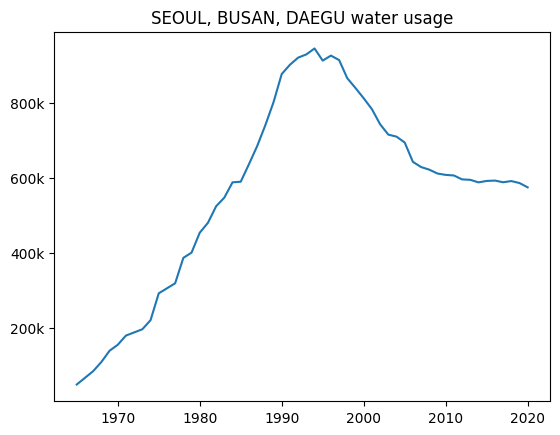

In [1]:
#상수도 이용량 - API
import requests
import json
import numpy as np
import matplotlib.pyplot as plt

url = "http://www.wamis.go.kr:8080/wamis/openapi/wks/wks_wsuaa_lst" # API URL
# 쿼리 파라미터 - 11:서울특별시, 26:부산광역시, 27:대구광역시
params = [{"admcd": "11"}, {"admcd": "26"}, {"admcd": "27"}]
w = []; year=[]
for i in range(3): 
    response = requests.get(url, params=params[i]) # params[0~2]
    data = response.text # 기본값 json
    root = json.loads(data) # type(root) = dict
    
    for lst in root['list']: # type(lst) = list
        w.append(float(lst['wsuse'])) 
        year.append(int(lst['year']))

# 배열 분할 (서울, 부산, 대구)
w_arr = np.array(w) # numpy 배열로 변환
w1, w2, w3 = np.array_split(w_arr, 3) # 3분할
wsuse = np.mean([w1, w2, w3], axis=0) #평균, y축 데이터
year1 = year[:len(year)//3]
 
 # 그래프 그리기
fig, ax1 = plt.subplots()
ax1.plot(year1, wsuse)
plt.title("SEOUL, BUSAN, DAEGU water usage")
# y축 값 단위 변경 (K)
formatter = plt.FuncFormatter(lambda x, _: f"{int(x/1000)}k")
ax1.yaxis.set_major_formatter(formatter)

plt.show()


[1134612, 1157017, 1169585, 1149881, 1162266, 1156808, 1153160, 1164635, 1177117, 1187288, 1194678, 1194291, 1210624, 1219227, 1265304, 1281996, 1310537, 1334914, 1387588, 1479693, 1526721, 1591821, 1673817, 1785452, 1826809, 1810000, 1875088, 1837435, 1834487, 1799188]


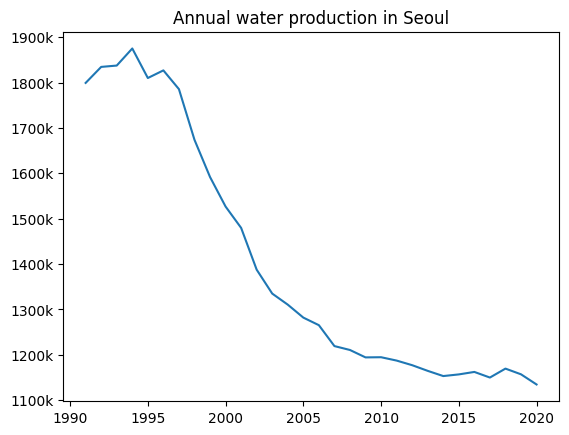

In [2]:
# 상수도 생산량 - Web Crawling
import time 
from selenium import webdriver
from selenium.webdriver.common.by import By
driver = webdriver.Chrome()
driver.get("http://www.wamis.go.kr/wks/wks_wspdqaa_lst.do")
time.sleep(3)

# x축 y축으로 쓸 데이터 크롤링
year2 =[]; output=[]
for i in range(1, 31):
    tem = driver.find_element(By.XPATH, f"/html/body/div[7]/div/div[4]/table/tbody/tr[{i}]/td[1]").text
    year2.append(int(tem)) #연도
    tem = driver.find_element(By.XPATH, f"/html/body/div[7]/div/div[4]/table/tbody/tr[{i}]/td[2]").text
    output.append(int(tem.replace(',',''))) #연간 생산량
    
driver.quit()

# 그래프 생성
fig, ax2 = plt.subplots()
ax2.plot(year2, output)
ax2.set_title("Annual water production in Seoul")
# y축 단위 조정
ax2.yaxis.set_major_formatter(formatter)
plt.show()


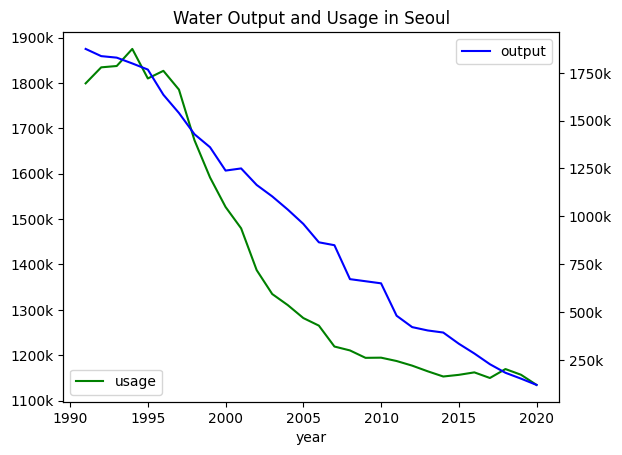

In [3]:
# 그래프 병합 - y축 분리
# 그래프 생성 - 상수도 생산량
fig, ax2 = plt.subplots()
ax2.plot(year2, output,color='green')
ax2.set_title("Water Output and Usage in Seoul")
ax2.set_xlabel("year")
ax2.yaxis.set_major_formatter(formatter)

# 새로운 그래프 추가 - 상수도 이용량
wsuse_cut = w1[-30:][::-1] #1965~2020 -> 1991~2020 슬라이싱
ax3 = ax2.twinx() #두 개의 축 설정
ax3.plot(year2, wsuse_cut, color='blue')
ax3.yaxis.set_major_formatter(formatter)
# 범례 설정
ax2.legend(["usage"], loc='lower left')
ax3.legend(["output"], loc='upper right')
plt.show()


In [3]:
import pandas as pd
from geopy.geocoders import Nominatim
import folium
# 주소 데이터 파일 읽기
Drought = pd.read_csv('drought.csv', encoding='euc-kr')
geolocator = Nominatim(user_agent='pythonproject') # 사용자 정의

# 주소 데이터에 대해 반복적으로 처리
for index, row in Drought.iterrows():
    
    address = row['시도'] + ' ' + row['시군']  # 주소 추출
    location = geolocator.geocode(address)  # geocode 호출    
    latitude = location.latitude # 위도
    longitude = location.longitude # 경도 
    # 첫번째 인덱스를 기준으로 지도객체 생성
    if index==0:
        map_kr = folium.Map(location=[latitude, longitude],zoom_start=8) 
    # 마커 색상 설정
    reservoir_ratio = row['대비']
    if reservoir_ratio < 75:
        fill_color = 'red' # 위험
    elif reservoir_ratio <85:
        fill_color = 'orange' # 주의
    else:
        fill_color = 'green' # 안전
    # 팝업 텍스트 설정
    popup_text = f"""
        <b>시도: </b>{row['시도']}<br><b>시군: </b>{row['시군']}<br>
        <b>저수지개수: </b>{row['시설개수']}<br><b>유효저수량(ha): </b>{row['유효저수량(ha)']}<br>
        <b>저수율: </b>{row['저수율']}<br><b>평년: </b>{row['평년']}<br>
        <b>대비: </b>{row['대비']}"""
    popup = folium.Popup(popup_text, max_width=400)
    # 마커 생성
    marker = folium.CircleMarker(
            location=[latitude, longitude],
            radius=10,
            color='black',
            fill_color=fill_color,
            fill_opacity=0.7, 
            popup=popup
        )    
    marker.add_to(map_kr)
# 지도 출력
map_kr